![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings_JSL/Legal/80.1.Legal_Graphs_Neo4j.ipynb)

# Colab Setup

In [ ]:
# Install the johnsnowlabs library to access Spark-OCR and Spark-NLP for Healthcare, Finance, and Legal.
! pip install johnsnowlabs

In [ ]:
from johnsnowlabs import nlp, legal
# After uploading your license run this to install all licensed Python Wheels and pre-download Jars the Spark Session JVM
# Make sure to restart your notebook afterwards for changes to take effect
nlp.install(force_browser=True)

<IPython.core.display.Javascript object>

127.0.0.1 - - [13/Jan/2023 13:57:19] "GET /login?code=ljjwetatEF2FtFd9NGfSHaYSMcIWgE HTTP/1.1" 200 -


<IPython.core.display.Javascript object>

Licenses extracted successfully
📋 Stored John Snow Labs License in /root/.johnsnowlabs/licenses/license_number_0_for_Spark-Healthcare_Spark-OCR.json
👷 Setting up  John Snow Labs home in /root/.johnsnowlabs, this might take a few minutes.
🙆 JSL Home setup in /root/.johnsnowlabs
Installing /root/.johnsnowlabs/py_installs/spark_nlp_jsl-4.2.4-py3-none-any.whl to /usr/bin/python3
Running: /usr/bin/python3 -m pip install /root/.johnsnowlabs/py_installs/spark_nlp_jsl-4.2.4-py3-none-any.whl
Installed 1 products:
💊 Spark-Healthcare==4.2.4 installed! ✅ Heal the planet with NLP! 


In [ ]:
# Restart your runtime after running this cell.
!pip install neo4j
!pip install tqdm
!pip install --user graphistry[all]

In [ ]:
from johnsnowlabs import nlp, legal
# Automatically load license data and start a session with all jars user has access to
spark = nlp.start()

👌 Launched cpu optimized session with with: 🚀Spark-NLP==4.2.4, 💊Spark-Healthcare==4.2.4, running on ⚡ PySpark==3.1.2


In [ ]:
import os
import sys
import time
import json
import neo4j
import functools 
import graphistry
import numpy as np
from tqdm import tqdm
from scipy import spatial
from neo4j import GraphDatabase
from neo4j import GraphDatabase, Driver

print('neo4j', neo4j.__version__)
print('graphistry', graphistry.__version__)

neo4j 5.2.1
graphistry 0.28.7


###Establishing a connection with Neo4j Sandbox and pygraphistry

In [ ]:
class Neo4jConnection:
    
    def __init__(self, uri, user, pwd):
        
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None
        
        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)
        
    def close(self):
        
        if self.__driver is not None:
            self.__driver.close()
        
    def query(self, query, parameters=None, db=None):
        
        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None
        
        try: 
            session = self.__driver.session(database=db) if db is not None else self.__driver.session() 
            response = list(session.run(query, parameters))
        except Exception as e:
            print("Query failed:", e)
        finally: 
            if session is not None:
                session.close()
        return response


In [ ]:
import neo4j
from neo4j import GraphDatabase
from neo4j import GraphDatabase, Driver


uri = 'bolt://3.93.153.8:7687'
pwd = 'thanks-pails-adherences'
user= 'neo4j'

#Create a Neo4J sandbox connection (https://neo4j.com/sandbox/)
conn = Neo4jConnection(uri=uri, user=user , pwd=pwd)

NEO4J = {
    'uri': uri, 
    'auth': ("neo4j", pwd)
}

# user,MY_PASSWORD = '',''

# create an account in graphistry for visualization and use the username and password here. (https://www.graphistry.com/)
graphistry.register(api=3,bolt=NEO4J,username=user, password=MY_PASSWORD)




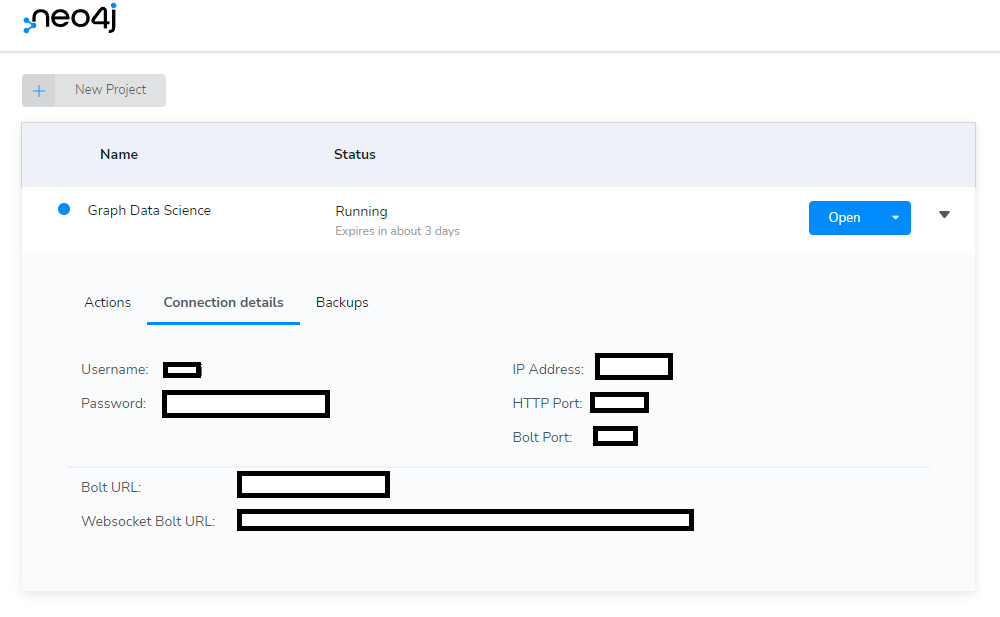

#Available graphs in ChunkMappers

In [ ]:
sec_results = [
    """Fig Publishing, Inc.""",
    """AWA Group LP""",
    """DatChat, Inc.""",
    """iConsumer Corp."""]
    

In [ ]:
documentAssembler = nlp.DocumentAssembler()\
        .setInputCol("text")\
        .setOutputCol("document")

chunkAssembler = nlp.Doc2Chunk() \
    .setInputCols("document") \
    .setOutputCol("chunk") \
    .setIsArray(False)
#to change
CM = legal.ChunkMapperModel()\
      .pretrained("legmapper_edgar_companyname", "en", "legal/models")\
      .setInputCols(["chunk"])\
      .setOutputCol("mappings")

cm_pipeline = nlp.Pipeline(stages=[documentAssembler, chunkAssembler, CM])

legmapper_edgar_companyname download started this may take some time.
[OK!]


In [ ]:
text = [""]
test_data = spark.createDataFrame([text]).toDF("text")
fit_cm_pipeline = cm_pipeline.fit(test_data)

In [ ]:
from collections import defaultdict
import pandas as pd
import pyspark.sql.functions as F


dicti = defaultdict(list)

for i in sec_results:
    kk = fit_cm_pipeline.transform(spark.createDataFrame([[i]]).toDF("text"))
    cm_res = []
    cm_res.append(kk.collect())
    for r in cm_res:
        json_dict = dict()
        json_dict['mappings'] = []
        for n in r[0]['mappings']:
            json_dict['mappings'].append([str(n.annotatorType), n.begin, n.end, str(n.result), {k:v for k,v in n.metadata.items()}])
    for i in json_dict['mappings']:
        dicti[i[4]['relation']].append(i[3])
    #     print(i[3],'--->',i[4]['relation'])  
    # print('-------------------------------')

df = pd.DataFrame(dicti)

In [ ]:
df

,name,sic,sic_code,irs_number,fiscal_year_end,state_location,state_incorporation,business_street,business_city,business_state,business_zip,business_phone,former_name,former_name_date,date,company_id
0,"Fig Publishing, Inc.",SERVICES-PREPACKAGED SOFTWARE [7372],7372,475336565,931,CA,DE,599 THIRD STREET,SAN FRANCISCO,CA,94107,(415) 689-5789,,,2017-01-23,1658966
1,AWA Group LP,INVESTMENT ADVICE [6282],6282,371785232,630,NC,DE,116 SOUTH FRANKLIN STREET,ROCKY MOUNT,NC,27804,952-446-6678,,,2017-01-23,1645148
2,"DatChat, Inc.",TELEGRAPH & OTHER MESSAGE COMMUNICATIONS [4822],4822,472502264,1231,NJ,NV,65 CHURCH STREET,NEW BRUNSWICK,NJ,08901,7323544768,"Dat Chat, Inc",20150722,2017-01-12,1648960
3,iConsumer Corp.,SERVICES-PERSONAL SERVICES [7200],7200,274286597,1231,FL,DE,19821 NW 2ND AVE SUITE 351,MIAMI GARDENS,FL,33169,8003726095,,,2017-01-18,1652350


###Generate csv for Neo4j

In [ ]:
df.to_csv('graphs.csv',index=False)

To use the CSV in Neo4j there are a couple of ways mentioned [here](https://neo4j.com/developer/kb/import-csv-locations/). I have used the one where we upload it to google sheets and then publish it to web and then use the link that is generated in here.

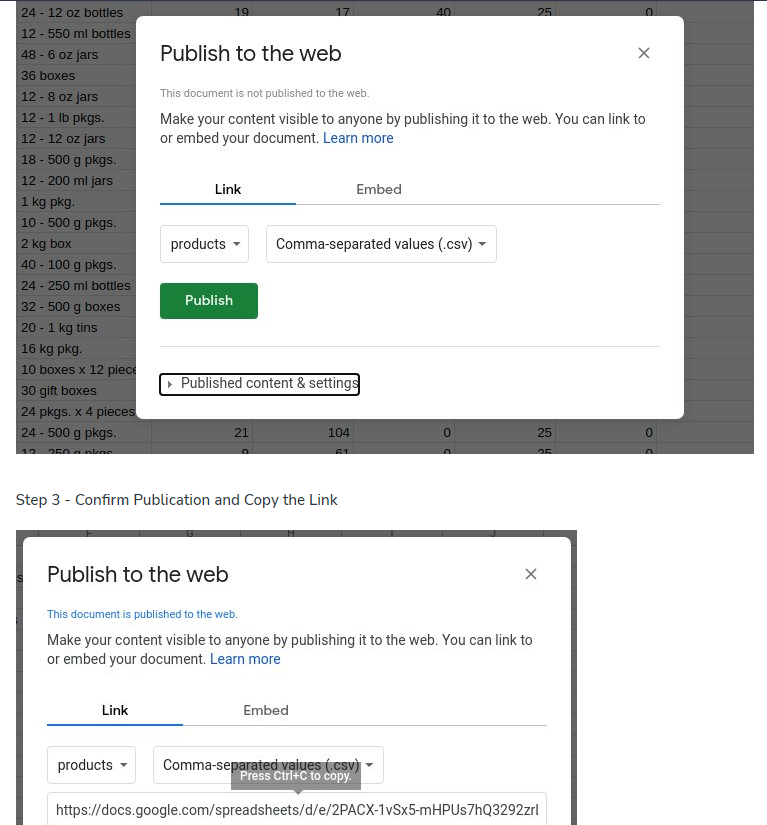

###Visualization using Neo4j and graphistry

In [ ]:
query = '''
    // create an array of maps, using the keys() function
    LOAD CSV WITH HEADERS FROM 'https://docs.google.com/spreadsheets/d/e/2PACX-1vSSFwFkyFQgMwb_WyW8LYC0mN-7tFgt3jsiO3uq6D1atKG05w8gxSxQUytqpl1BUTbOs3ErjdO1eeWY/pub?gid=419410490&single=true&output=csv' as row
    with row.name AS company,
        [key IN keys(row) WHERE key<>'name' | {relType:key,location:row[key]}] as relTypeLocs

    WHERE row.name = 'DatChat, Inc.'

    unwind relTypeLocs AS relTypeLoc



    merge (l:locations {name:COALESCE(relTypeLoc.location,'Unknown')})



    merge (t:tokens {name:company})



    WITH l,t,



        relTypeLoc.relType AS relType



    // use apoc to create the rels



    CALL apoc.create.relationship(t,relType,{}, l) YIELD rel



    RETURN *
    '''

In [ ]:
result = conn.query(query)

result

[<Record l=<Node element_id='0' labels=frozenset({'locations'}) properties={'name': '1648960'}> rel=<Relationship element_id='63' nodes=(<Node element_id='1' labels=frozenset({'tokens'}) properties={'name': 'DatChat, Inc.'}>, <Node element_id='0' labels=frozenset({'locations'}) properties={'name': '1648960'}>) type='company_id' properties={}> relType='company_id' t=<Node element_id='1' labels=frozenset({'tokens'}) properties={'name': 'DatChat, Inc.'}>>,
 <Record l=<Node element_id='2' labels=frozenset({'locations'}) properties={'name': 'NJ'}> rel=<Relationship element_id='64' nodes=(<Node element_id='1' labels=frozenset({'tokens'}) properties={'name': 'DatChat, Inc.'}>, <Node element_id='2' labels=frozenset({'locations'}) properties={'name': 'NJ'}>) type='state_location' properties={}> relType='state_location' t=<Node element_id='1' labels=frozenset({'tokens'}) properties={'name': 'DatChat, Inc.'}>>,
 <Record l=<Node element_id='3' labels=frozenset({'locations'}) properties={'name': '4

In [ ]:
g = graphistry.cypher(query)
print(g._edges.columns)
# g.plot()

g.plot()

Index(['_bolt_relationship_id', 'type', '_bolt_start_node_id_key',
       '_bolt_end_node_id_key'],
      dtype='object')


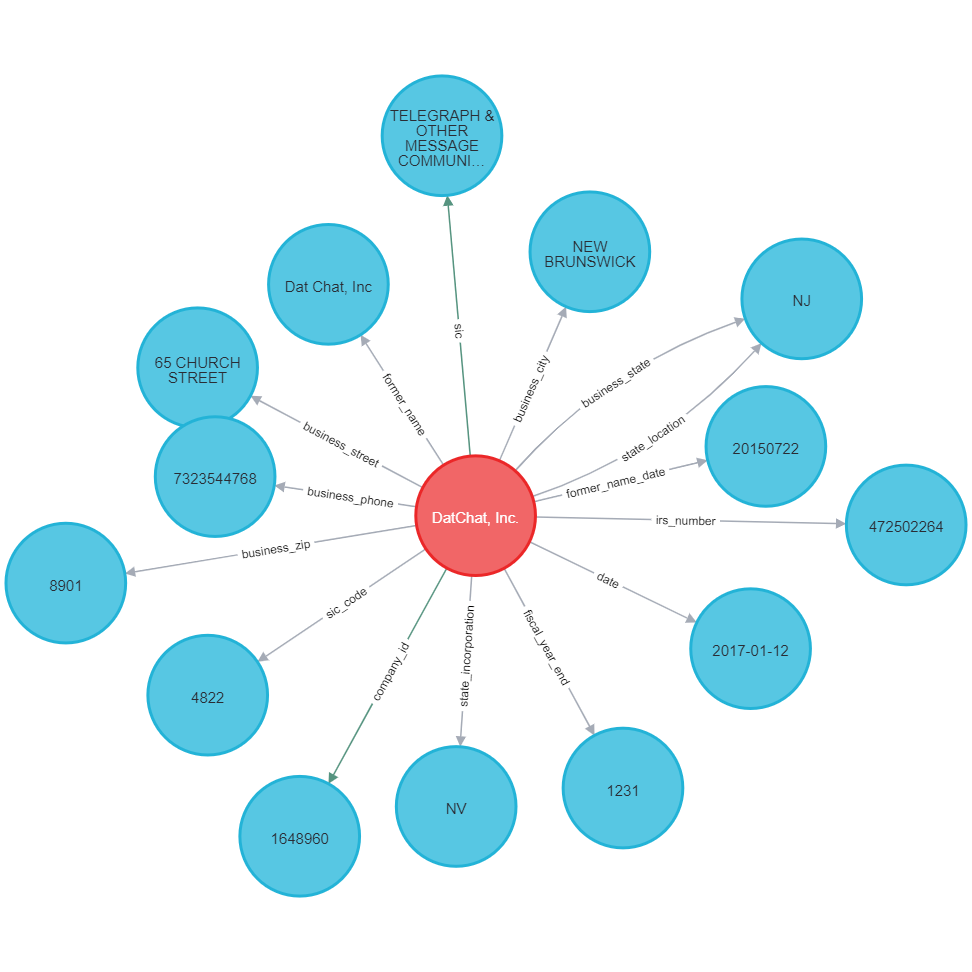

#Graphs with NER and Relation Extraction

In [ ]:
documentAssembler = nlp.DocumentAssembler()\
  .setInputCol("text")\
  .setOutputCol("document")

"""sentenceDetector = SentenceDetectorDLModel.pretrained("sentence_detector_dl","xx")\
        .setInputCols(["document"])\
        .setOutputCol("sentence")"""

tokenizer = nlp.Tokenizer()\
  .setInputCols("document")\
  .setOutputCol("token")

embeddings = nlp.RoBertaEmbeddings.pretrained("roberta_embeddings_legal_roberta_base", "en") \
        .setInputCols("document", "token") \
        .setOutputCol("embeddings")\
        .setMaxSentenceLength(512)

ner_model = legal.NerModel.pretrained('legner_contract_doc_parties', 'en', 'legal/models')\
        .setInputCols(["document", "token", "embeddings"])\
        .setOutputCol("ner")

ner_converter = nlp.NerConverter()\
        .setInputCols(["document","token","ner"])\
        .setOutputCol("ner_chunk")

"""
ONLY NEEDED IF YOU WANT TO FILTER RELATION PAIRS OR SYNTACTIC DISTANCE
pos_tagger = PerceptronModel()\
    .pretrained("pos_clinical", "en", "clinical/models") \
    .setInputCols(["document", "tokens"])\
    .setOutputCol("pos_tags")

dependency_parser = DependencyParserModel() \
    .pretrained("dependency_conllu", "en") \
    .setInputCols(["document", "pos_tags", "tokens"]) \
    .setOutputCol("dependencies")

# Set a filter on pairs of named entities which will be treated as relation candidates
re_filter = RENerChunksFilter()\
    .setInputCols(["ner_chunks", "dependencies"])\
    .setOutputCol("re_ner_chunks")\
#    .setMaxSyntacticDistance(7)\
#    .setRelationPairs(['PARTY-ALIAS', 'DOC-PARTY', 'DOC-EFFDATE'])
"""
reDL = legal.RelationExtractionDLModel.pretrained('legre_contract_doc_parties', 'en', 'legal/models')\
    .setPredictionThreshold(0.5)\
    .setInputCols(["ner_chunk", "document"])\
    .setOutputCol("relations")

roberta_embeddings_legal_roberta_base download started this may take some time.
Approximate size to download 447.2 MB
[OK!]
legner_contract_doc_parties download started this may take some time.
[OK!]
legre_contract_doc_parties download started this may take some time.
[OK!]


In [ ]:
pipeline = nlp.Pipeline(stages=[
    documentAssembler,
    tokenizer,
    embeddings,
    ner_model,
    ner_converter,
    reDL
])
"""sentenceDetector,
pos_tagger,
    dependency_parser,
    re_filter,
"""

'sentenceDetector,\npos_tagger,\n    dependency_parser,\n    re_filter,\n'

In [ ]:
text=['''
This INTELLECTUAL PROPERTY AGREEMENT (this "Agreement"), dated as of December 31, 2018 (the "Effective Date") is entered into by and between Armstrong Flooring, Inc., a Delaware corporation ("Seller") and AFI Licensing LLC, a Delaware limited liability company ("Licensing" and together with Seller, "Arizona") and AHF Holding, Inc. (formerly known as Tarzan HoldCo, Inc.), a Delaware corporation ("Buyer") and Armstrong Hardwood Flooring Company, a Tennessee corporation (the "Company" and together with Buyer the "Buyer Entities") (each of Arizona on the one hand and the Buyer Entities on the other hand, a "Party" and collectively, the "Parties").
''']

data = spark.createDataFrame([text]).toDF("text")
model = pipeline.fit(data)


In [ ]:
lmodel = nlp.LightPipeline(model)

In [ ]:
import pandas as pd

def get_relations_df (results, col='relations'):
  rel_pairs=[]
  for rel in results[0][col]:
      rel_pairs.append((
          rel.result, 
          rel.metadata['entity1'], 
          rel.metadata['entity1_begin'],
          rel.metadata['entity1_end'],
          rel.metadata['chunk1'], 
          rel.metadata['entity2'],
          rel.metadata['entity2_begin'],
          rel.metadata['entity2_end'],
          rel.metadata['chunk2'], 
          rel.metadata['confidence']
      ))

  rel_df = pd.DataFrame(rel_pairs, columns=['relation','entity1','entity1_begin','entity1_end','chunk1','entity2','entity2_begin','entity2_end','chunk2', 'confidence'])

  return rel_df

In [ ]:
for i in range(len(text)):
    results = lmodel.fullAnnotate(text)
    rel_df = get_relations_df (results)
    rel_df = rel_df[rel_df['relation']!='no_rel']
    print(rel_df.to_string(index=False))
    print()

            relation entity1 entity1_begin entity1_end                              chunk1 entity2 entity2_begin entity2_end                  chunk2 confidence
            dated_as     DOC             6          36     INTELLECTUAL PROPERTY AGREEMENT EFFDATE            70          86       December 31, 2018 0.98433614
           signed_by     DOC             6          36     INTELLECTUAL PROPERTY AGREEMENT   PARTY           142         164 Armstrong Flooring, Inc  0.6040471
           has_alias   PARTY           142         164             Armstrong Flooring, Inc   ALIAS           193         198                  Seller 0.96357507
           has_alias   PARTY           206         222                   AFI Licensing LLC   ALIAS           264         272               Licensing 0.95466775
           has_alias   PARTY           316         331                    AHF Holding, Inc   ALIAS           612         616                   Party  0.5387175
           has_alias   PARTY           3

###Visualization using Neo4j and graphistry

In [ ]:
def update_data(query, rows, batch_size = 10000):
    # Function to handle the updating the Neo4j database in batch mode.
    # Especially for large datasets.
    total = 0
    batch = 0
    start = time.time()
    result = None

    while batch * batch_size < len(rows):

        res = conn.query(query, parameters={'rows': rows[batch*batch_size:(batch+1)*batch_size].to_dict('records')})
        total += res[0]['total']
        batch += 1
        result = {"total":total, "batches":batch, "time":time.time()-start}
        print(result)

    return result

In [ ]:
def add_ners_rels(rows, batch_size=10000):
    # Adds NER nodes to the Neo4j graph as a batch job.
    query = '''
    //chunk1 NERs
    UNWIND $rows as row
    MERGE(n1:NER{name:row.chunk1}) ON CREATE SET n1.type=row.entity1

    //chunk2 NERs
    MERGE(n2:NER{name:row.chunk2}) ON CREATE SET n2.type=row.entity2

    //connect NERs
    WITH row, n1, n2
    MERGE (n1)-[:LINKS{relation:row.relation}]->(n2)
    RETURN count(*) as total  
    '''

    return update_data(query, rows, batch_size)

In [ ]:
add_ners_rels(rel_df)

{'total': 16, 'batches': 1, 'time': 0.10175251960754395}


{'total': 16, 'batches': 1, 'time': 0.10175251960754395}

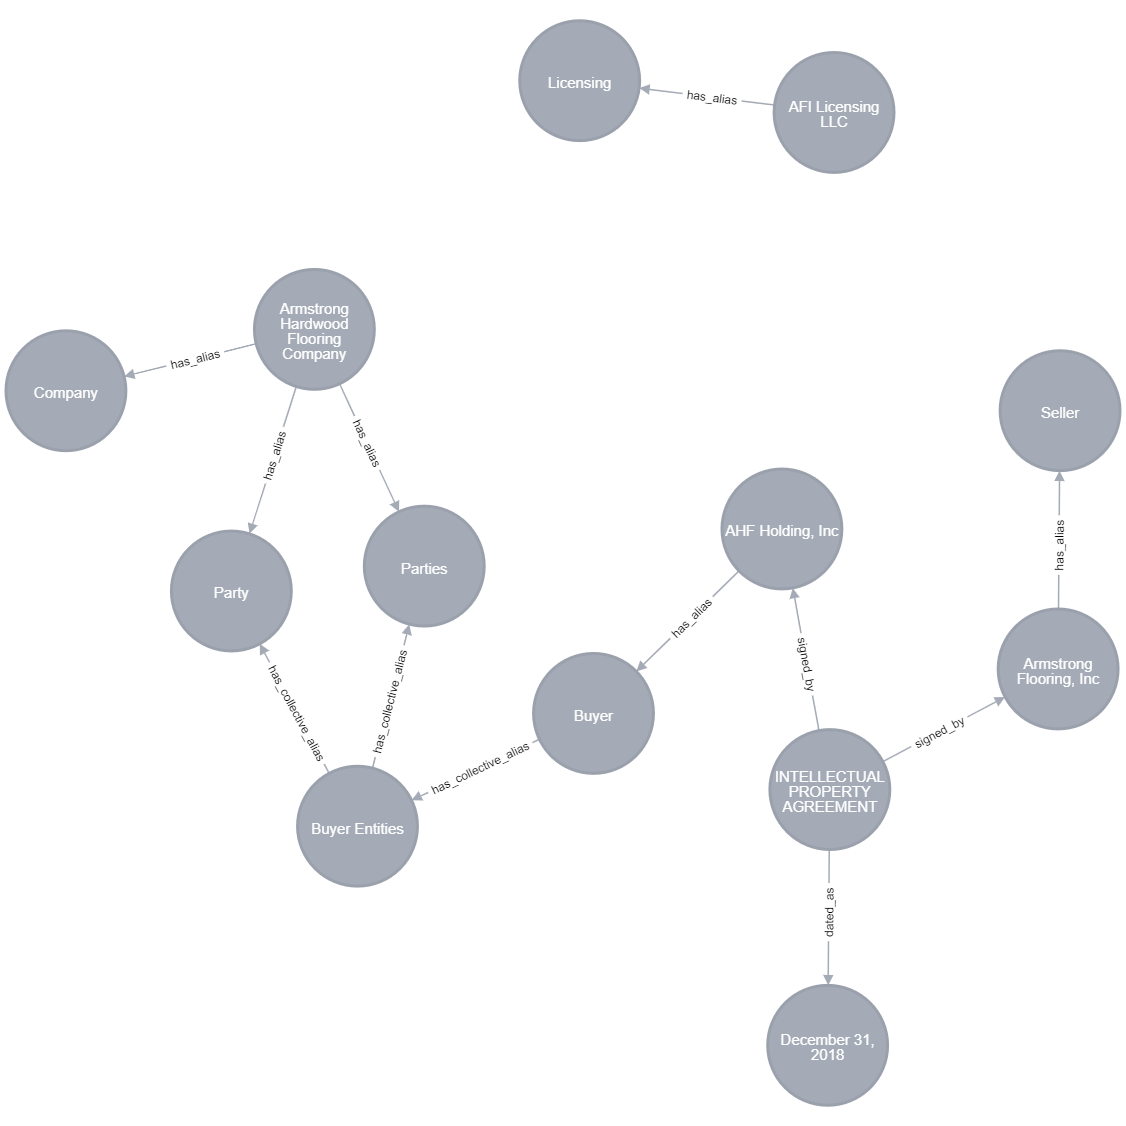

In [ ]:
rel_df.to_csv('relations.csv',index=False)

In [ ]:
import pandas as pd
matches_df = pd.read_csv('/content/relations.csv')
matches_df.columns


Index(['relation', 'entity1', 'entity1_begin', 'entity1_end', 'chunk1',
       'entity2', 'entity2_begin', 'entity2_end', 'chunk2', 'confidence'],
      dtype='object')

In [ ]:
(graphistry
  .edges(matches_df, 'chunk1',
        'chunk2')
  .nodes(matches_df, 'relation','entity1','entity2')
).plot() 